# Explore the correlation between Tsys and WVR data

### Author: Hao He

ALMA high-frequency observation at Band 9 and Band 10 requires multiple Tsys measurements (more than 10) due to rapid sky variation. This is the project to explore the possibility to track system temeprature with alternative dataset (e.g. WVR, auto-correlation or SQLD data). 

In [1]:
# packags and functions
import pickle
import numpy as np
import matplotlib.pyplot as plt

def map_series_by_dict(a, d):

    v = np.array(list(d.values()))
    k = np.array(list(d.keys()))
    sidx = k.argsort()
    out_ar = v[sidx[np.searchsorted(k,a,sorter=sidx)]]
    return out_ar

def normalize_array(array, iants, obs_type):

    array_norm = np.full(np.shape(array), fill_value=np.nan)
    iants_uq = np.unique(iants)
    obsType_uq = np.unique(obs_type)
    for iant in iants_uq:
        for obs in obsType_uq:
            conditions = ((iants == iant) & (obs_type==obs))
            indices = np.where(conditions)
            array_sub = array[indices]
            array_norm[indices] = array_sub / array_sub[0]

    return array_norm

def extrapolate_array(array, array_norm, iants, obs_type):

    array_ext = np.full(np.shape(array), fill_value=np.nan)
    iants_uq = np.unique(iants)
    obsType_uq = np.unique(obs_type)
    for iant in iants_uq:
        for obs in obsType_uq:
            conditions = ((iants == iant) & (obs_type==obs))
            indices = np.where(conditions)
            array_start = array[indices][0]
            array_norm_sub = array_norm[indices]
            array_ext[indices] = array_start * array_norm_sub

    return array_ext

### Import the data

Specify the filename. The file is from the script "Tsys_WVR_correlation_run.casa.py". 

In [2]:
filename = 'Tsys_WVR_correlation_chanWVR3_spwTsysavg_avgTime10.pkl'
# filename = 'Tsys_WVR_correlation_chanWVRavg_spwTsys17_avgTime10.pkl'
# filename = 'Tsys_WVR_correlation_chanWVRavg_spwTsysavg_avgTime10.pkl'
# filename = 'Tsys_autCorr_correlation_spwautCorr24_spwTsysavg_avgTime10.pkl'

# load the data
with open (filename, 'rb') as pickle_file:
    Tsys_table = pickle.load(pickle_file)

Get the information of the data

In [3]:
info = Tsys_table['info']

keywords_title = ', '.join('{}  {}'.format(key, value) for key, value in info.items())
keywords_filename = '_'.join('{}{}'.format(key, value) for key, value in info.items())
keywords_filename = keywords_filename.replace(' ','')

In [4]:
iants = Tsys_table['iant']
iants_bad = np.array([30,33,36])
obs_type = Tsys_table['obs_type']
obs_type = obs_type.astype(str)

Import the matched Tsys and WVR values

In [5]:
WVR_means = Tsys_table['WVR_means']
WVR_norms = Tsys_table['WVR_norms']
Trx = Tsys_table['Trx']
Tsky = Tsys_table['Tsky']
Tsky_norms = Tsys_table['Tsky_norm']
Tsys = Tsys_table['Tsys']
Tsys_norms = Tsys_table['Tsys_norm']

Import the optical depth

In [6]:
tau_mean = Tsys_table['tau_mean']

Exclude the data from bad antennas

In [7]:
# exclude the bad antennas
WVR_means[np.isin(iants, iants_bad)] = np.nan
WVR_norms[np.isin(iants, iants_bad)] = np.nan
tau_mean[np.isin(iants, iants_bad)] = np.nan

Calculate the extrapolated sky temperature

In [8]:
Tsky_ext = extrapolate_array(Tsky, WVR_norms, iants, obs_type)
tau_ext = - np.log(1 - Tsky/275)
Tsys_ext = (Trx+Tsky_ext) * np.exp(tau_mean)
Tsys_ext_norms = normalize_array(Tsys_ext, iants, obs_type)

### Export the correlation between Tsys and WVR

Plot the Tsys vs WVR

No handles with labels found to put in legend.


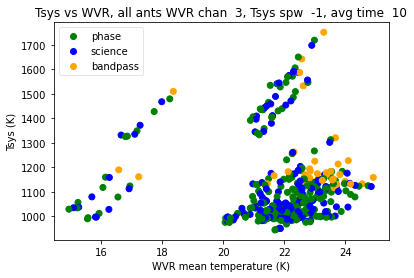

In [9]:
fig = plt.figure()
ax = plt.subplot(111)

# create color dictionary for the scatter plot
color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
# color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

# plot the scatter plot
sc = ax.scatter(WVR_means, Tsys, c=map_series_by_dict(obs_type, color_dict))

# title
title = 'Tsys vs WVR, all ants '+keywords_title
plt.title(title)

# label
plt.xlabel('WVR mean temperature (K)')
plt.ylabel('Tsys (K)')
plt.legend(loc='upper left', framealpha=0.5)
plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

Normalize the Tsys and WVR value to the first of the measurement for each antenna

No handles with labels found to put in legend.


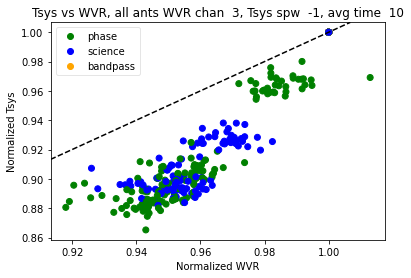

In [10]:
fig = plt.figure()
ax = plt.subplot(111)

# create color dictionary for the scatter plot
color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
# color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

# plot the scatter plot
sc = ax.scatter(WVR_norms, Tsys_norms, c=map_series_by_dict(obs_type, color_dict))

# plot the 1-to-1 line
lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
ax.plot([lower, upper],[lower,upper],ls='--', color='black')

# title
title = 'Tsys vs WVR, all ants '+keywords_title
plt.title(title)

# label
plt.xlabel('Normalized WVR')
plt.ylabel('Normalized Tsys')
plt.legend(loc='upper left', framealpha=0.5)
plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

### Export the correlation between the Tsky and the WVR value

No handles with labels found to put in legend.


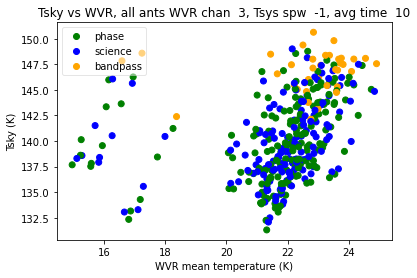

In [11]:
fig = plt.figure()
ax = plt.subplot(111)

# create color dictionary for the scatter plot
color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
# color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

# plot the scatter plot
sc = ax.scatter(WVR_means, Tsky, c=map_series_by_dict(obs_type, color_dict))

# title
title = 'Tsky vs WVR, all ants '+keywords_title
plt.title(title)

# label
plt.xlabel('WVR mean temperature (K)')
plt.ylabel('Tsky (K)')
plt.legend(loc='upper left', framealpha=0.5)
plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

No handles with labels found to put in legend.


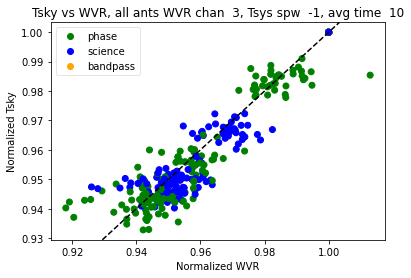

In [12]:
fig = plt.figure()
ax = plt.subplot(111)

# create color dictionary for the scatter plot
color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
# color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

# plot the scatter plot
sc = ax.scatter(WVR_norms, Tsky_norms, c=map_series_by_dict(obs_type, color_dict))

# plot the 1-to-1 line
lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
ax.plot([lower, upper],[lower,upper],ls='--', color='black')

# title
title = 'Tsky vs WVR, all ants '+keywords_title
plt.title(title)

# label
plt.xlabel('Normalized WVR')
plt.ylabel('Normalized Tsky')
plt.legend(loc='upper left', framealpha=0.5)
plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)